# Chocolate Bar Reviews
by Nicholas Archambault
### Original Question
*Suppose you are given the following dataset of chocolate bar ratings, contained in the CSV file `flavors_of_cacao.csv`. Write an SQL query to summarize the `BroadBeanOrigin` for U.S. manufactured chocolate bars and provide the number of reviews, average rating, and average cocoa percentage.*

### Solution
At first glance, this prompt is relatively straightforward, but further investigation reveals some potential pitfalls, especially in extending the scope of the prompt to explore results graphically. Let's dive in.

We can start by importing the usual packages and tools. Since this prompt asks us to write an SQL query, we'll include the `SQLalchemy` package, which will allow us to create an SQL connection and construct a query in traditional SQL format.

Given that the dataset includes geographic information about the origin of the cacao beans used to produce various chocolate bars, it might be intriguing to explore map-based visualizations. For charting purposes, let's also import the `geopandas` package, a new tool for me that I'm excited to learn about.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pycountry
import geopandas
from sqlalchemy import create_engine
from matplotlib.pyplot import figure

# Set parameters for figures
plt.rcParams['figure.dpi'] = 200

# Establish SQL engine
engine = create_engine('sqlite://', echo = False)

We can read in the data and modify the column names to a more intuitive form.

In [2]:
chocolate = pd.read_csv("flavors_of_cacao.csv")
chocolate.columns = ["company", "bean_origin", "ref", "review_date", "cocoa_pct", "company_location", "rating", "bean_type", "broad_bean_origin"]
chocolate.head()

,company,bean_origin,ref,review_date,cocoa_pct,company_location,rating,bean_type,broad_bean_origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


Viewing the 'head' of the data, we immediately see that not all rows are complete. Thorough exploration of a dataset usually involves investigating the prevalence of values that may need to be imputed or eliminated, and we can check how many `NULL` entries are found in each column.

In [3]:
chocolate.isnull().sum(axis = 0)

company              0
bean_origin          0
ref                  0
review_date          0
cocoa_pct            0
company_location     0
rating               0
bean_type            1
broad_bean_origin    1
dtype: int64

Only two columns contain a single `NULL` value, and there are nearly 1,800 rows in the dataset, each of which represents an individual chocolate bar. Rather than trying to impute these two values, let's just drop the rows in which they're found.

In [4]:
chocolate = chocolate.drop([chocolate[chocolate["bean_type"].isnull()].index[0], chocolate[chocolate["broad_bean_origin"].isnull()].index[0]])

The prompt asks us to pull the total number of reviews as well as the average rating and average cocoa percentage for all chocolate bars manufactured in the United States. We know we'll need to interact with the `cocoa_pct` column as a series of numeric values; right now, however, it is cast as a string type with a percent sign attached to the cocoa percentage value.

We can use a clever list comprehension to strip the percent sign from each value in the series and recast the individual values to floats so they can be numerically aggregated and manipulated.

In [5]:
chocolate.cocoa_pct = pd.Series([i.strip("%") for i in list(chocolate.cocoa_pct)]).astype(float)

We're gradually working through the data cleaning process and readying the dataset for querying, but major issues still exist within some of the columns we care about, specifically `broad_bean_origin`, which denotes the country of origin for the cacao beans used in each chocolate bar. Examining the tail of the data shows missing values within that column that will almost certainly be problematic when we eventually craft the SQL query to summarize chocolate bars by origin.

In [6]:
chocolate.tail(20)

,company,bean_origin,ref,review_date,cocoa_pct,company_location,rating,bean_type,broad_bean_origin
1775,Zokoko,Alto Beni,697,2011,72.0,Australia,3.50,,Bolivia
1776,Zokoko,Tokiala,701,2011,80.0,Australia,3.50,Trinitario,Papua New Guinea
1777,Zokoko,"Tranquilidad, Baures",701,2011,72.0,Australia,3.75,,Bolivia
1778,Zotter,Raw,1205,2014,65.0,Austria,2.75,,
1779,Zotter,"Bocas del Toro, Cocabo Co-op",801,2012,70.0,Austria,3.50,,Panama
1780,Zotter,Amazonas Frucht,801,2012,70.0,Austria,3.50,,
1781,Zotter,"Satipo Pangoa region, 16hr conche",875,2012,62.0,Austria,3.00,Criollo (Amarru),Peru
1782,Zotter,"Satipo Pangoa region, 20hr conche",875,2012,75.0,Austria,3.50,Criollo (Amarru),Peru
1783,Zotter,"Loma Los Pinos, Yacao region, D.R.",875,2012,75.0,Austria,3.75,,Dominican Republic
1784,Zotter,El Oro,879,2012,90.0,Austria,3.00,Forastero (Nacional),Ecuador


These missing values did not reveal themselves when we examined the `NULL` frequencies of each column, meaning we must use an alternative method to remove them. Using a regular expression that eliminates every row where `broad_bean_origin` does not contain an alphanumeric value ought to do the trick.

In [7]:
chocolate = chocolate[chocolate.broad_bean_origin.str.contains("\w").astype(bool)]

With the regex filtering out missing data for cacao bean origin, we have pared the data from 1,795 entries to 1,720. Reducing the dataset by about 4.2% is not a cause for concern; at a higher threshold we might reconsider this step of data removal.

Knowing there are no missing `broad_bean_origin` entries, we can check the unique values this column takes on.

In [8]:
pd.set_option("display.max_rows", None)
chocolate.broad_bean_origin.value_counts()

Venezuela                        214
Ecuador                          193
Peru                             165
Madagascar                       145
Dominican Republic               141
Nicaragua                         60
Brazil                            58
Bolivia                           57
Belize                            49
Papua New Guinea                  42
Colombia                          40
Vietnam                           38
Costa Rica                        38
Tanzania                          34
Trinidad                          33
Ghana                             33
Mexico                            30
Guatemala                         28
Hawaii                            28
Domincan Republic                 25
Jamaica                           20
Grenada                           19
Indonesia                         16
Honduras                          15
Cuba                              11
Congo                             10
Sao Tome                          10
H

The top of the list looks encouraging, with a number of familiar country names well-represented in the data. Moving further down the list, however, reveals that additional cleaning will be necessary to transform the data into a useful form. Spelling mistakes, abbreviations, and generalizations abound – there is an entry for the 'Domincan Republic' rather than the 'Dominican Republic', for example, as well as numerous bean origin locations defined by region instead of country. Other entries use alternative names when referring to the same country or combine the names of multiple nations.

Once again, string parsing tools like regular expressions and the `str.replace()` function can resolve these issues.

In [9]:
# Recode specific reference to Dominican Republic
chocolate.broad_bean_origin.replace("Domincan Republic", "Dominican Republic", inplace = True)

# Combine disparate entries referring to Sao Tome & Principe 
chocolate.loc[chocolate.broad_bean_origin.str.contains("Sao Tome|Principe").astype(bool), "broad_bean_origin"] = "Sao Tome & Principe"

# Classify Hawaii by its country – the United States
chocolate.broad_bean_origin.replace("Hawaii", "United States", inplace = True)

# Recode specific reference to Peru
chocolate.loc[chocolate.broad_bean_origin.str.contains("nacional").astype(bool), "broad_bean_origin"] = "Peru"

# Recode specific reference to Venezuela
chocolate.loc[chocolate.broad_bean_origin.str.contains("Venezuela, Caribbean").astype(bool), "broad_bean_origin"] = "Venezuela"

# Combine disparate entries referring to Trinidad & Tobago
chocolate.loc[chocolate.broad_bean_origin.str.contains(r"^Tobago$|^Trinidad$|Trinidad.*Tobago").astype(bool), "broad_bean_origin"] = "Trinidad & Tobago"

# Utilize regular expression to fix all remaining instances of generalization and combination
chocolate.loc[chocolate.broad_bean_origin.str.contains(r",|\(|\)|/|and S\.|car &|Caribbean|Carribean|America|Africa|Ghana &").astype(bool), "broad_bean_origin"] = "unspecified"

Though all these steps are important to rendering clean, consistent data, the last might be the most crucial of all. Each previous step addresses a specific error or type of error pertaining to a particular country, but the regular expression serves as a catch-all to eliminate the most pervasive errors of generalization or combination, wherein bean origin is listed as a region, like 'South America', or a combination of places, like 'Madagascar & Ecuador'. Not only are these errors' naming conventions obstacles to our goal of creating map-based visuals, the formatting issues and inconsistencies they present lead to a distorted picture of cacao bean origin.

The regular expression searches for all remaining entries that do not purely contain a single country name – those with symbols, misspellings, regions, or multiple origin sources – and classifies them as having "unspecified" cacao bean origin. Though these entries represent just 3.5% of the data and we could easily eliminate them, it may be interesting to chart how chocolate bars made with beans of "unspecified" origin compare to those made with country-specific types of beans.

With all data preparation complete, we finally arrive at the query itself. The language of the prompt indicates that we will use a number of aggregation methods, namely `COUNT` on the `num_reviews` column and `AVG` on the `rating` and cleaned `cocoa_pct` columns. We likely want to express these numeric values not as messy-tailed percentages but as concise, interpretable figures, so we should expect to employ the `ROUND` function as well.

We know that we only want to include U.S. manufactured chocolate bars, so we'll need a `WHERE` clause controlling such behavior. Additionally, the prompt asks us to "summarize `broad_bean_origin`", seeming to hint that we will group these averages and counts by country of bean origin. A `GROUP BY` clause is in order, as is a `HAVING` clause to filter these grouped results and an `ORDER BY` clause to make sense of them.

In [10]:
chocolate.to_sql(name = 'chocolate_sql', con = engine)

query = pd.DataFrame(engine.execute(
    '''
        SELECT
            broad_bean_origin,
            COUNT(ref) AS reviews,
            ROUND(AVG(rating), 2),
            ROUND(AVG(cocoa_pct) / 100, 3)
        FROM chocolate_sql
        WHERE company_location = 'U.S.A.'
        GROUP BY broad_bean_origin
        HAVING reviews > 5
        ORDER BY 3 DESC
    '''
).fetchall())

query.columns = ["bean_origin", "num_reviews", "avg_rating", "cocoa_pct"]

query

,bean_origin,num_reviews,avg_rating,cocoa_pct
0,Papua New Guinea,13,3.38,0.702
1,Honduras,10,3.38,0.714
2,Brazil,19,3.33,0.723
3,Guatemala,13,3.31,0.714
4,Belize,36,3.28,0.724
5,Vietnam,8,3.25,0.724
6,Trinidad & Tobago,13,3.23,0.720
7,Madagascar,57,3.23,0.713
8,Ecuador,71,3.23,0.716
9,Tanzania,18,3.21,0.707


The above query pulls four columns, which have been renamed appropriately, for all chocolate bars manufactured in the United States. It aggregates the total number of reviews, average rating, and average cocoa content among American-made bars according to the home nations of cacao beans used in those bars, then eliminates all countries with less than six total consumer reviews across all bars made with its beans.

While this step satisfies the requirements of the posed question, we can proceed further with this data now that it has been cleaned and filtered. It might be fun to examine things from a geographic perspective, starting with grouping countries by region to see where higher rated chocolate bars tend to be sourced from.

In [11]:
query["region"] = pd.Series(["Oceania/Asia", "Caribbean", "South America", "Caribbean", "Caribbean", "Oceania/Asia", "Caribbean", "Africa", "South America", "Africa", "North America", "Caribbean", "Caribbean", "South America", "South America", "South America", "Caribbean", "unspecified", "Caribbean", "Africa", "North America"])
grouped = query.iloc[:, 1:5].groupby("region")

After creating a new `region` column with manually imputed regional classifications and grouping the data into a new dataset, we can construct a bubble plot examining average rating and average cocoa percentage by country, with region denoted.

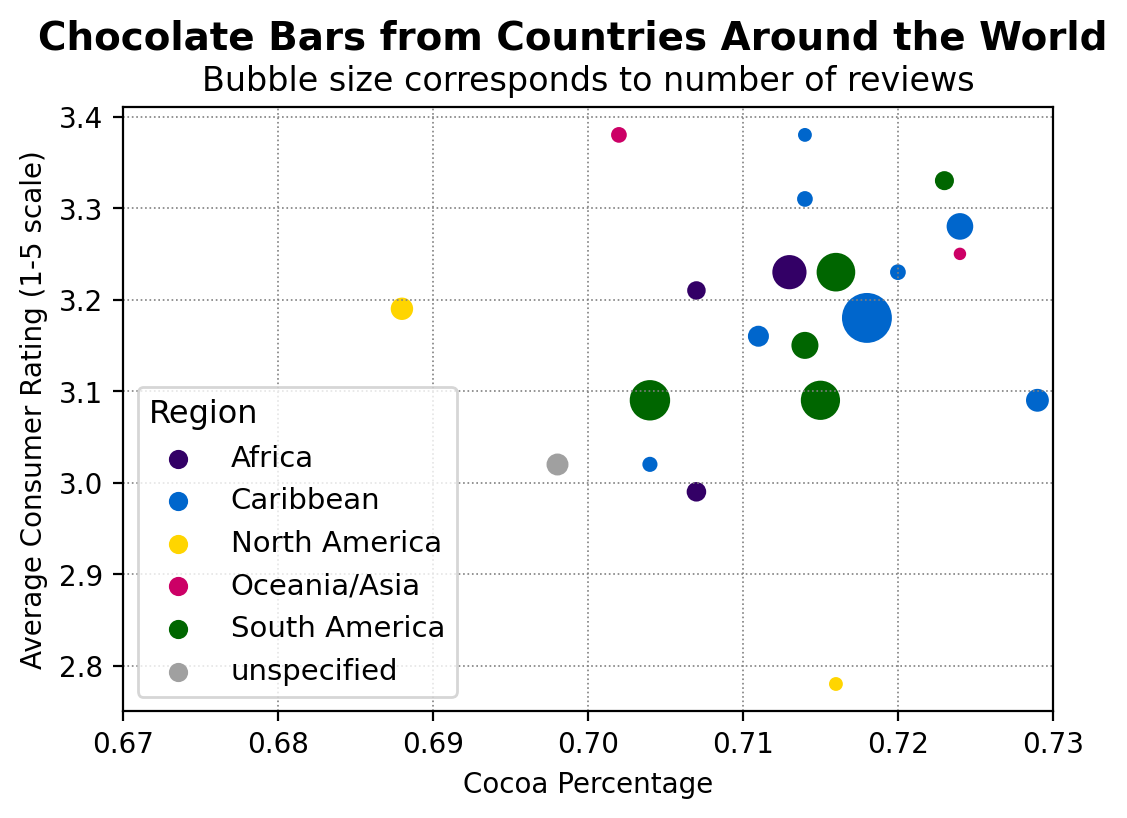

In [12]:
plt.grid(color = "grey", linestyle = "dotted", linewidth = 0.6)
plt.xlim(0.67, 0.73)
plt.suptitle("Chocolate Bars from Countries Around the World", fontsize = 14, fontweight = "bold", y = 0.99)
plt.title("Bubble size corresponds to number of reviews")
plt.xlabel("Cocoa Percentage")
plt.ylabel("Average Consumer Rating (1-5 scale)")

# Craft legend
colors = ["#330066", "#0066CC", "#FFD500", "#CC0066", "#006600", "#A0A0A0"]
counter = 0

for name, group in grouped:
    plt.scatter(group.cocoa_pct, group.avg_rating, marker = "o", label = name, c = colors[counter], s = group.num_reviews ** 1.2)
    counter += 1

lgnd = plt.legend(loc = "lower left", scatterpoints = 1, fontsize = 10.5, title = "Region", title_fontsize = 11.5)
lgnd._legend_box.align = "left"
for handle in lgnd.legendHandles:
    handle.set_sizes([35])

plt.show()

Each point represents a different country of bean origin. Point color indicates that country's global region, and bubble size is proportional to the number of a reviews received by all chocolate bars with beans from that country.

The plot provides much more information than could be gleaned from the query alone. We see that there is a modest positive association between cocoa content and average rating; it seems that consumers are more likely rate highly chocolate bars with higher cocoa content. It is also possible that bars of objectively higher quality tend to be higher in cocoa content, so we should be carefuly before firmly labeling this association a noteworthy finding. 

From the density of bubbles, it appears that most cacao beans are produced in South America and the Caribbean. Chocolate with beans from Oceania/Asia, though not heavily represented, seems to score well with consumers nonetheless. 

North American-sourced chocolate bars lie at the fringes of the graph, though the United States seems to buck the larger trend. Its beans generate lower-cocoa chocolate bars that are still looked upon relatively favorably by consumers. Perhaps this has to do with the prevalence of 'candy-type' chocolate bars designed to appeal to a broader audience rather than chocolate aficionados specifically.

Finally, we observe that the "unspecified" grouping is not highly ranked in either cocoa content or consumer satisfaction. Further investigation would be needed to deteremine the stability of this trend, but it's possible consumers tend to prefer chocolate bars made with beans that are sourced from the same place due to the way their chemistry or flavors interact. It's also conceivable that objectively lowly-rated bars are those that choose to generalize or obfuscate their beans' origin and that this tactic functions as a flag of their low quality.

Given that we are examining things through a geographical lens, it makes sense to create a map. We can do this with the help of the `geopandas` package. First, though, we'll need to adapt the data into a form that can be assimilated by that package.

The first step in that adaptation process is to generate the internationally-recognized 'alpha-3' three-digit code for each country. Using tools native to the `pycountry` package we can create a function that guesses the alpha-3 code for the countries returned from the query.

In [13]:
def alpha3code(column):
    CODE = []
    for country in column:
        try:
            code = pycountry.countries.get(name = country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

trial = alpha3code(query.bean_origin)

Of the 20 countries specified in the data, the function correctly matches the alpha-3 code for 15 of them. We can manually impute the codes of the other five, with a label of "None" for the "unspecified" entry.

In [14]:
c = 0
replacements = ["VNM", "TTO", "TZA", "BOL", "VEN", "None"]
for i in range(len(trial)):
    if trial[i] == "None":
        trial[i] = replacements[c]
        c += 1

After creating a new column containing these alpha-3 codes, we can drop the "unspecified" entry since it cannot be plotted on any map.

In [15]:
query["code"] = pd.Series(trial)
query.drop(query[query.code == "None"].index[0])

,bean_origin,num_reviews,avg_rating,cocoa_pct,region,code
0,Papua New Guinea,13,3.38,0.702,Oceania/Asia,PNG
1,Honduras,10,3.38,0.714,Caribbean,HND
2,Brazil,19,3.33,0.723,South America,BRA
3,Guatemala,13,3.31,0.714,Caribbean,GTM
4,Belize,36,3.28,0.724,Caribbean,BLZ
5,Vietnam,8,3.25,0.724,Oceania/Asia,VNM
6,Trinidad & Tobago,13,3.23,0.720,Caribbean,TTO
7,Madagascar,57,3.23,0.713,Africa,MDG
8,Ecuador,71,3.23,0.716,South America,ECU
9,Tanzania,18,3.21,0.707,Africa,TZA


From `geopandas`, we now read in the shape file containing information for plotting a map of Earth, then merge our queried data with this new dataset using a left join.

In [16]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world.columns = ["population", "continent", "country", "code", "gdp", "geometry"]

# Eliminate Antarctica
world = world[(world.population > 0) & (world.country != "Antarctica")]

# Merge data
merged = pd.merge(world, query, "left", on = "code")
merged.head()

,population,continent,country,code,gdp,geometry,bean_origin,num_reviews,avg_rating,cocoa_pct,region
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000...",NaN,NaN,NaN,NaN,NaN
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",Tanzania,18.0,3.21,0.707,Africa
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",NaN,NaN,NaN,NaN,NaN
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742...",NaN,NaN,NaN,NaN,NaN
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000...",United States,26.0,3.19,0.688,North America


The merged dataset, as we can see, contains chocolate bar information only for our 20 queried countries, but cartographical information for all countries besides Antarctica. Using the `missing_kwds` argument of the plotting function, we specify that we still want these countries to show up on the map, though they will be greyed out due to lack of information on bean production or ratings.

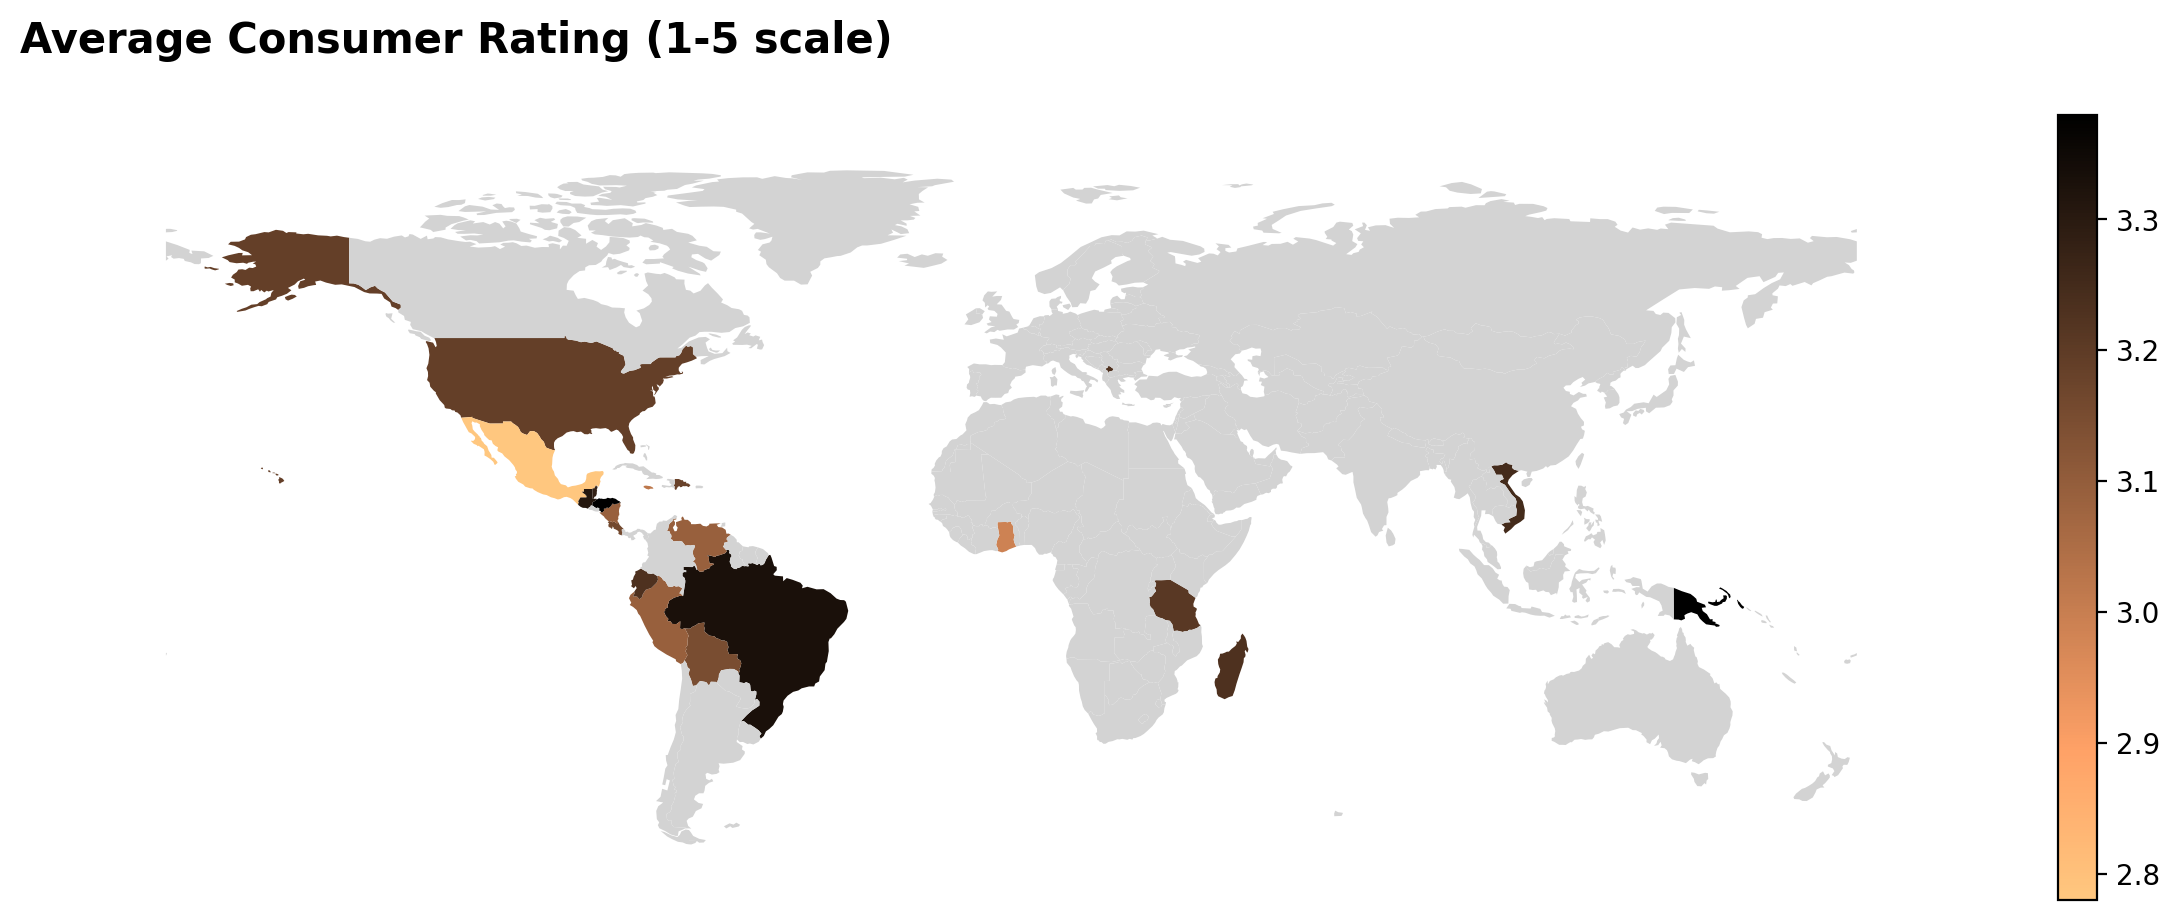

In [17]:
ax = world.plot(column = merged.avg_rating, 
                missing_kwds = {'color': 'lightgrey'}, 
                figsize = (15, 13), 
                cmap = "copper_r", 
                legend = True, 
                legend_kwds = {'shrink':0.4})
ax.set_axis_off()
plt.suptitle("Average Consumer Rating (1-5 scale)", x = 0.25, y = 0.69, fontsize = 15, fontweight = "bold")
plt.show()

Though a bit barren – since our queried data comprises only about 10% of the world's nations – the map provides an alternative and more aesthetic visualization with which to understand disparities in consumer perceptions of countries' cacao beans. Our previous findings are shown in a new way: consumer ratings are generally high across South America and strong as well in the only two Asian nations, but span a wider range in North America.